In [1]:
from src.deep_research_agent.agents.research_agent import researcher_agent
from IPython.display import Image, display
from src.utils.notebook_utils import format_messages
from langchain_core.messages import HumanMessage, SystemMessage,ToolMessage, AIMessage
from src.utils.models import get_model

/Users/gaurav/Documents/projects/OpenDeepResearch/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [2]:
async def graph_stream_generator(agent,state):
    result = None
    async for mode,chunk in agent.astream (
        state,
        stream_mode=["messages","custom","values"]
    ):
        # Print custom values
        if mode == "custom":
            msg = chunk.get("message",None)
            if msg:
                print(msg)

        # Print llm messages from selected nodes
        if mode == "messages":
            if chunk[1]["langgraph_node"] == "compress_research" and chunk[0].content!='':
                print(chunk[0].content, end="", flush=True)
                
        # Save final response
        if mode == "values" and chunk:
            result = chunk

    return result

In [3]:
# Example brief
research_brief = """I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  
on coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, 
using coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      
expert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      
location, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    
sources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     

Coffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  
customer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of
the top coffee shops in San Francisco, emphasizing their coffee quality according to the latest available data as  
of July 2025."""

# result = researcher_agent.invoke({"researcher_messages": [HumanMessage(content=f"{research_brief}.")]})
# format_messages(result['researcher_messages'])

result = await graph_stream_generator(researcher_agent,
    {
        "researcher_messages": [
            HumanMessage(
                content=research_brief
            )
        ],
        "research_topic":research_brief
    }
)


ValidationError: 1 validation error for web_search
runtime
  Field required [type=missing, input_value={'query': 'best coffee sh...ffee quality July 2025'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.12/v/missing

In [8]:
result

{'researcher_messages': [HumanMessage(content='I want to identify and evaluate the coffee shops in San Francisco that are considered the best based specifically  \non coffee quality. My research should focus on analyzing and comparing coffee shops within the San Francisco area, \nusing coffee quality as the primary criterion. I am open regarding methods of assessing coffee quality (e.g.,      \nexpert reviews, customer ratings, specialty coffee certifications), and there are no constraints on ambiance,      \nlocation, wifi, or food options unless they directly impact perceived coffee quality. Please prioritize primary    \nsources such as the official websites of coffee shops, reputable third-party coffee review organizations (like     \n\nCoffee Review or Specialty Coffee Association), and prominent review aggregators like Google or Yelp where direct  \ncustomer feedback about coffee quality can be found. The study should result in a well-supported list or ranking of\nthe top coffee 

In [10]:
from src.deep_research_agent.tools.search_tool import summarize_webpage_content, Summary, SUMMARIZE_WEBPAGE_PROMPT_TEMPLATE,MODEL,web_search
from src.utils.helpers import get_prompt_template, get_today_str


In [8]:
structured_model = MODEL.with_structured_output(Summary)

content_data = [
        SystemMessage(
            content=SUMMARIZE_WEBPAGE_PROMPT_TEMPLATE.render(
                webpage_content=content, date=get_today_str()
            )
        )
    ]
response = structured_model.invoke(content_data)

In [9]:
response

Summary(summary='The “Dining Out in SF” page is a December‑2025 snapshot of San\u202fFrancisco’s newest dining scene.  Written by Dianne de\u202fGuzman and Paolo\u202fBicchieri, the article previews a slate of new restaurants—including an upscale English pub, a soba spot in Japantown, and a duck joint in the Tenderloin—and links to an updated map of the city’s best new eateries.  It also highlights a growing coffee‑shop scene: Hedge Coffee Roasters (434\u202fShotwell\u202fSt., SF\u202f94110) opens its own roasting facility; Q Specialty Coffee (3490a\u202fCalifornia\u202fSt., SF\u202f94118) adds matcha‑yuzu and nitro‑cold‑brew options; and Q Specialty Coffee’s Pacific Heights location expands its menu.  The page’s “Latest” section showcases recent reviews from December\u202f10, 2025—Pearl, Joodooboo, Mandalay, Bella, and Bangkok Street—while the “More in Dining Out in SF” links lead to curated maps of classic restaurants, brunch spots, holiday bars, and more.  Overall, the page serves a

In [40]:

from langchain_ollama import ChatOllama

model = ChatOllama(
    model="gpt-oss:20b",
    validate_model_on_init=True,
    temperature=None,
    # num_predict=256,
    # # other params ...
    reasoning=None
)
# model = get_model(reasoning=None,validate_model_on_init=True)

In [41]:
think_start =False
for chunk in model.stream(content_data):
    if chunk.additional_kwargs.get("reasoning_content",None):
        if not think_start:
            think_start = True
            print("\n[THINKING...]\n", end="", flush=True)
        print(chunk.additional_kwargs["reasoning_content"], end="", flush=True)
    else:
        if think_start:
            think_start = False
            print("\n[END THINKING]\n", end="", flush=True)
        print(chunk.content, end="", flush=True)

```json
{
  "summary": "The page is a San Francisco‑wide guide to coffee shops, offering concise reviews and key details for each venue. It showcases a variety of cafés—from intimate counter‑service spots like Caffe V and Ibarra, to larger roaster‑cafés such as Hedge Coffee Roasters and Q Specialty Coffee. For each coffee shop, the guide lists the address, phone number, and official website, along with a snapshot of what makes the shop distinct: signature drinks (e.g., matcha yuzu, nitro cold brew, espresso cold foam), roasting practices, and seating capacity. Notable highlights include:\n\n- **Caffe V** (1518 S Harbor St., SF) offers a four‑seat counter and a menu of classic espresso drinks. Phone: 415‑722‑3226.\n- **Ibarra** (123 Burling Ave., SF) serves a full espresso menu and has a 20‑seat patio; it can also take private parties. Phone: 415‑822‑3220.\n- **Rive** (600 S Geary, SF) has a small roastery café and a 15‑seat patio; it focuses on a seasonal menu of cold‑brew drinks. Phon

In [48]:
from langchain_core.callbacks import BaseCallbackHandler

class DebugPromptCallback(BaseCallbackHandler):
    def on_llm_start(self, serialized, prompts, **kwargs):
        print("PROMPT SENT TO MODEL:")
        for p in prompts:
            print(p)

In [49]:
model = get_model(reasoning='low',callbacks=[DebugPromptCallback()])

In [50]:
model=model.bind_tools([web_search])

In [53]:
# Use web search to find the answer.
user_message = HumanMessage(content="WHo is the current prime minister of india and list of all prime ministers of India from 1947? You can use web search tool to find the answer for the questions you can't solve yourself. Use web search to search for the up to date data.")
response = model.invoke([user_message])

PROMPT SENT TO MODEL:
Human: WHo is the current prime minister of india and list of all prime ministers of India from 1947? You can use web search tool to find the answer for the questions you can't solve yourself. Use web search to search for the up to date data.


In [54]:
print(response.content)

In [55]:
response.additional_kwargs

{'reasoning_content': 'Need current PM and list all PMs since 1947. Use web search.'}

In [56]:
response.tool_calls

[{'name': 'web_search',
  'args': {'query': 'current prime minister of india 2025 list all prime ministers of india from 1947'},
  'id': '977d3261-f9da-490e-a336-c159f4d5f474',
  'type': 'tool_call'}]

In [58]:
response

AIMessage(content='', additional_kwargs={'reasoning_content': 'Need current PM and list all PMs since 1947. Use web search.'}, response_metadata={'model': 'gpt-oss', 'created_at': '2025-12-13T12:12:37.026174Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2603373167, 'load_duration': 1629624250, 'prompt_eval_count': 188, 'prompt_eval_duration': 242400417, 'eval_count': 58, 'eval_duration': 672847669, 'model_name': 'gpt-oss', 'model_provider': 'ollama'}, id='lc_run--b03ba118-3e25-48c4-befb-549c13a13732-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'current prime minister of india 2025 list all prime ministers of india from 1947'}, 'id': '977d3261-f9da-490e-a336-c159f4d5f474', 'type': 'tool_call'}], usage_metadata={'input_tokens': 188, 'output_tokens': 58, 'total_tokens': 246})

In [70]:
tm = ToolMessage(content="The prime minister is Modi",tool_call_id=response.tool_calls[0]["id"])

In [71]:
response2 =model.invoke([user_message,response,tm])

PROMPT SENT TO MODEL:
Human: WHo is the current prime minister of india and list of all prime ministers of India from 1947? You can use web search tool to find the answer for the questions you can't solve yourself. Use web search to search for the up to date data.
AI: 
Tool: The prime minister is Modi


In [72]:
response2

AIMessage(content='', additional_kwargs={'reasoning_content': 'Need up-to-date list. Search again for list.'}, response_metadata={'model': 'gpt-oss', 'created_at': '2025-12-13T12:23:59.10934Z', 'done': True, 'done_reason': 'stop', 'total_duration': 798362291, 'load_duration': 133243791, 'prompt_eval_count': 238, 'prompt_eval_duration': 121271667, 'eval_count': 45, 'eval_duration': 528960831, 'model_name': 'gpt-oss', 'model_provider': 'ollama'}, id='lc_run--c369d110-fca2-45f1-9b05-c4414896c0a0-0', tool_calls=[{'name': 'web_search', 'args': {'query': 'list of prime ministers of india 1947 to present'}, 'id': 'c84b2a19-f4a0-4076-a24e-08b24f9059dd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 238, 'output_tokens': 45, 'total_tokens': 283})

In [75]:
model.invoke(AIMessage(content=[
        {
            "type": "thinking",
            "thinking": "The user wants to know the current weather in Paris. I have access to a function `get_weather`...",
            "signature": "BDaL4VrbR2Oj0hO4XpJxT28J5TILnCrrUXoKiiNBZW9P+nr8XSj1zuZzAl4egiCCpQNvfyUuFFJP5CncdYZEQPPmLxYsNrcs...."
        },
        {
            "type": "text",
            "text": "I can help you get the current weather information for Paris. Let me check that for you"
        },
        {
            "type": "tool_use",
            "id": "toolu_01CswdEQBMshySk6Y9DFKrfq",
            "name": "get_weather",
            "input": {
                "location": "Paris"
            }
        }
    ]))

ValueError: Invalid input type <class 'langchain_core.messages.ai.AIMessage'>. Must be a PromptValue, str, or list of BaseMessages.

In [14]:
await web_search.ainvoke(input ={"query":"Prime minister of India 2024","runtime":ToolRuntime(),})

NameError: name 'ToolRuntime' is not defined

In [4]:
from langchain.tools import tool, ToolRuntime

In [5]:
ToolRuntime

langgraph.prebuilt.tool_node.ToolRuntime

In [6]:
from langgraph.prebuilt import tools_condition, ToolNode

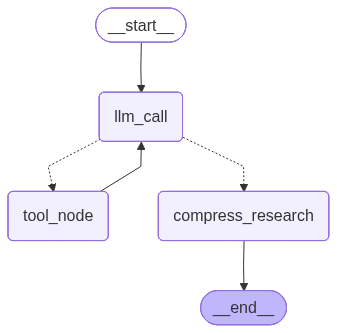

In [7]:
researcher_agent

In [8]:
from langgraph.graph import StateGraph, START, END
END


'__end__'

In [1]:
from src.deep_research_agent.agents.supervisor_agent import SupervisorResearchAgent
research_supervisor = SupervisorResearchAgent(
    interleaved_thinking=True, agent_reasoning='low'
).build_agent_graph()

/Users/gaurav/Documents/projects/OpenDeepResearch/.venv/lib/python3.14/site-packages/langchain_core/_api/deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


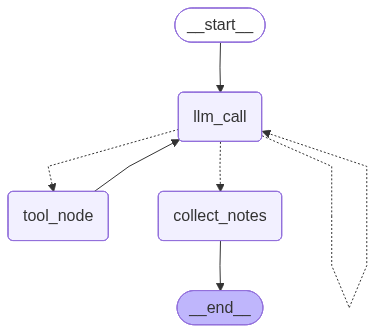

In [2]:
research_supervisor